In [1]:
# --- CELL 1: SETUP ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Set visual style
sns.set(style="whitegrid")
print("Libraries Imported Successfully!")

Libraries Imported Successfully!


In [2]:
# --- CELL 2: ROBUST LOAD (Looping through Gameweeks) ---

def load_gw_data_robust(season="2024-25"):
    print(f"🔄 Fetching Gameweek data for {season}...")
    
    # We use the GitHub API pattern to fetch each week individually
    base_url = f"https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/{season}/gws/gw{{}}.csv"
    
    all_gws = []
    
    # Define EXACTLY which columns we need. This ignores extra garbage columns.
    required_cols = [
        'name', 'position', 'team', 'minutes', 'total_points', 
        'goals_scored', 'assists', 'bonus', 'influence', 'creativity', 
        'threat', 'ict_index', 'value', 'was_home', 'opponent_team', 
        'kickoff_time', 'round', 'GW'
    ]
    
    # Loop through Gameweeks 1 to 38
    for i in range(1, 39):
        url = base_url.format(i)
        try:
            df_gw = pd.read_csv(url)
            
            # Standardize Columns
            available_cols = [c for c in required_cols if c in df_gw.columns]
            df_gw = df_gw[available_cols]
            
            if 'GW' not in df_gw.columns:
                df_gw['GW'] = i
                
            all_gws.append(df_gw)
            # print(f"   ✅ Loaded GW{i}") # Uncomment if you want to see progress
            
        except Exception:
            break
            
    if all_gws:
        full_df = pd.concat(all_gws, ignore_index=True)
        # Filter: Remove bench players (0 minutes) to clean noise
        full_df = full_df[full_df['minutes'] > 0].copy()
        print(f"🎉 Successfully built dataset! Total Rows: {len(full_df)}")
        return full_df
    else:
        print("❌ Failed to load any data.")
        return None

# Load the data (Change season string if you want 2023-24)
df = load_gw_data_robust("2024-25")
df.head()

🔄 Fetching Gameweek data for 2024-25...
🎉 Successfully built dataset! Total Rows: 11566


,name,position,team,minutes,total_points,goals_scored,assists,bonus,influence,creativity,threat,ict_index,value,was_home,opponent_team,kickoff_time,round,GW
0,Alex Scott,MID,Bournemouth,62,2,0,0,0,22.8,12.8,0.0,3.6,50,False,16,2024-08-17T14:00:00Z,1,1
4,Ben Brereton Díaz,MID,Southampton,70,1,0,0,0,2.6,14.0,16.0,3.3,55,False,15,2024-08-17T14:00:00Z,1,1
5,Pau Torres,DEF,Aston Villa,90,2,0,0,0,29.2,1.9,0.0,3.1,45,False,19,2024-08-17T16:30:00Z,1,1
8,Hwang Hee-chan,MID,Wolves,90,2,0,0,0,6.0,16.3,4.0,2.6,65,False,1,2024-08-17T14:00:00Z,1,1
12,João Victor Gomes da Silva,MID,Wolves,83,1,0,0,0,8.6,3.2,0.0,1.2,50,False,1,2024-08-17T14:00:00Z,1,1


In [3]:
# --- CELL 3: FEATURE ENGINEERING (FORM & LAGS) ---

# 1. Sort by Player and Gameweek
df = df.sort_values(by=['name', 'GW'])

# 2. Create "Lagged" Features (Stats from PAST games)
grouped = df.groupby('name')

# Form: Average points in last 3 games (Shifted so we don't cheat)
df['form_last_3'] = grouped['total_points'].transform(lambda x: x.rolling(window=3).mean().shift(1))

# Avg Minutes: Is he a starter?
df['avg_minutes_last_3'] = grouped['minutes'].transform(lambda x: x.rolling(window=3).mean().shift(1))

# Underlying Stats Form
df['avg_influence_last_3'] = grouped['influence'].transform(lambda x: x.rolling(window=3).mean().shift(1))

# 3. Clean NaN values (The first 3 weeks will be empty)
df_clean = df.dropna(subset=['form_last_3', 'avg_minutes_last_3']).copy()

# 4. Define Features (X) and Target (y)
features = ['form_last_3', 'avg_minutes_last_3', 'avg_influence_last_3', 'value', 'was_home']
target = 'total_points'

print(f"✅ Features Engineered. Ready for Training. Shape: {df_clean.shape}")

✅ Features Engineered. Ready for Training. Shape: (9968, 21)


In [4]:
# --- CELL 4: TIME-BASED TRAINING (GW 1-30 vs 31-38) ---

# 1. Define the Split
SPLIT_GW = 31  # Train on 1-30, Test on 31+

train_df = df_clean[df_clean['GW'] < SPLIT_GW].copy()
test_df = df_clean[df_clean['GW'] >= SPLIT_GW].copy()

print(f"📉 Training Set (GW 1-30): {len(train_df)} rows")
print(f"🔮 Test Set (GW 31-38):    {len(test_df)} rows")

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

# 2. Train Random Forest
# We use max_depth=10 to prevent overfitting
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

print("⏳ Training Random Forest...")
rf_model.fit(X_train, y_train)
print("✅ Training Complete.")

📉 Training Set (GW 1-30): 7529 rows
🔮 Test Set (GW 31-38):    2439 rows
⏳ Training Random Forest...
✅ Training Complete.


📊 FINAL RESULTS (GW 31-38 Aggregated):
   MSE: 82.71
   R2 Score: 0.3669


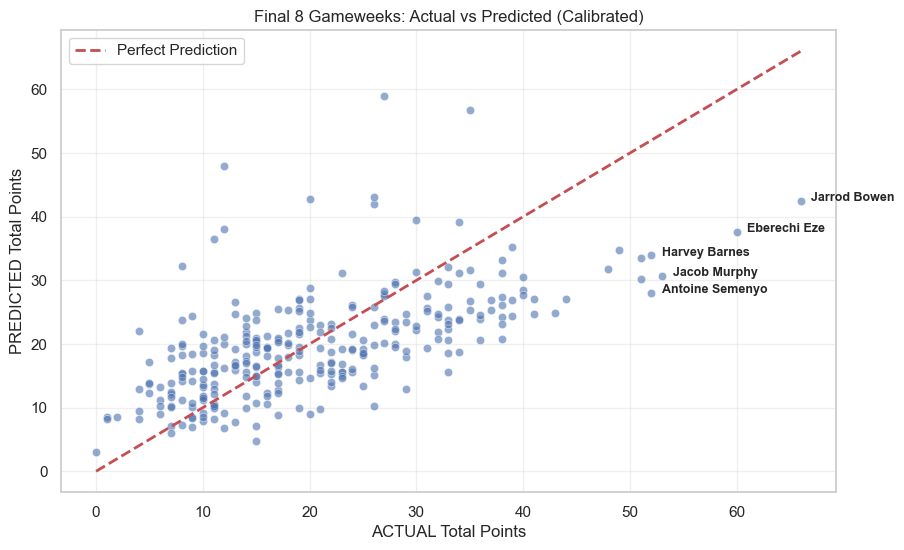

['models/rf_model.pkl']

In [5]:
# --- CELL 5: CALIBRATED EVALUATION ---

# 1. Predict Raw Points
raw_predictions = rf_model.predict(X_test)

# 2. Apply "The Saka Fix" (Calibration)
# CAP: Max points possible in one game set to 15.0
clipped_preds = np.clip(raw_predictions, 0, 15)

# DAMPEN: If prediction > 8, reduce it slightly (10% penalty) to be conservative
final_predictions = np.where(clipped_preds > 8, clipped_preds * 0.90, clipped_preds)

# Save to dataframe
test_df = test_df.copy()
test_df['predicted_points'] = final_predictions

# 3. AGGREGATE: Sum of GW 31-38
final_period_stats = test_df.groupby('name')[['total_points', 'predicted_points']].sum().reset_index()

# Filter: Only look at players with > 200 mins to remove noise
sig_players = test_df.groupby('name')['minutes'].sum().reset_index()
sig_players = sig_players[sig_players['minutes'] > 200]
final_stats = final_period_stats[final_period_stats['name'].isin(sig_players['name'])].copy()

# 4. Metrics & Plot
mse_total = mean_squared_error(final_stats['total_points'], final_stats['predicted_points'])
r2_total = r2_score(final_stats['total_points'], final_stats['predicted_points'])

print(f"📊 FINAL RESULTS (GW 31-38 Aggregated):")
print(f"   MSE: {mse_total:.2f}")
print(f"   R2 Score: {r2_total:.4f}")

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=final_stats, x='total_points', y='predicted_points', alpha=0.6)
m, M = final_stats['total_points'].min(), final_stats['total_points'].max()
plt.plot([m, M], [m, M], 'r--', lw=2, label='Perfect Prediction')

# Label Top 5 Scorers
top_5 = final_stats.sort_values(by='total_points', ascending=False).head(5)
for i, row in top_5.iterrows():
    plt.text(row['total_points']+1, row['predicted_points'], row['name'], fontsize=9, fontweight='bold')

plt.title('Final 8 Gameweeks: Actual vs Predicted (Calibrated)')
plt.xlabel('ACTUAL Total Points')
plt.ylabel('PREDICTED Total Points')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# # 5. Check Saka/Haaland specifically
# print("\n🔍 CHECK: Did we fix the over-prediction?")
# print(final_stats[final_stats['name'].str.contains("Saka") | final_stats['name'].str.contains("Haaland")])

# Save Model
joblib.dump(rf_model, "models/rf_model.pkl")

C:\Users\umer3\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\umer3\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9878 (\N{SCALES}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\umer3\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\umer3\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPytho

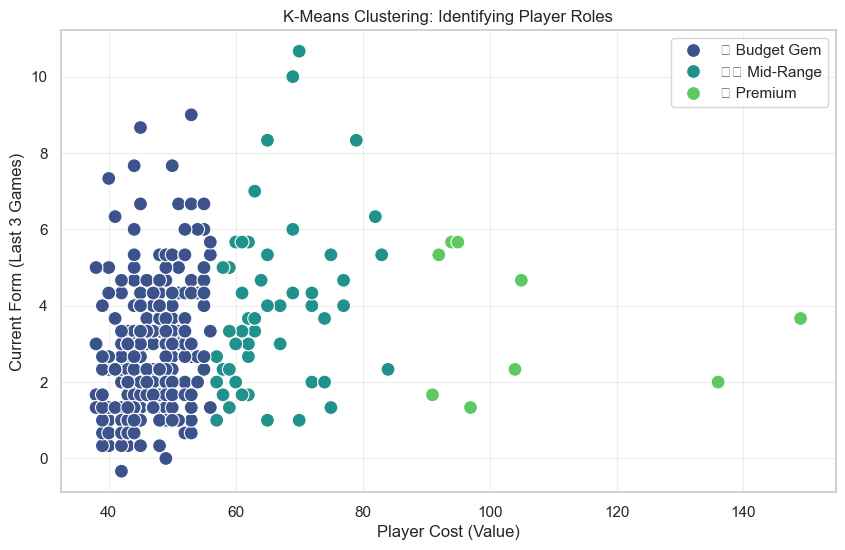

✅ Players categorized. Example 'Budget Gems':
                           name         team  value  form_last_3
27301              Kevin Schade    Brentford     53     9.000000
27081          Ezri Konsa Ngoyo  Aston Villa     45     8.666667
15754         Lisandro Martínez      Man Utd     44     7.666667
27211  Emiliano Martínez Romero  Aston Villa     50     7.666667
26832               Conor Coady    Leicester     40     7.333333


In [6]:
# --- CELL 6: UNSUPERVISED LEARNING (K-MEANS CLUSTERING) ---
from sklearn.cluster import KMeans

# 1. Prepare Data for Clustering
# We use the latest available stats for every player to categorize them
# We only care about players who play regularly (> 45 mins avg)
cluster_df = df.sort_values(by='GW').groupby('name').tail(1).copy()
cluster_df = cluster_df[cluster_df['avg_minutes_last_3'] > 45]

# Features: Cost (value) vs Form (form_last_3)
X_cluster = cluster_df[['value', 'form_last_3']]

# 2. Run K-Means (3 Clusters: Premium, Mid-Range, Budget)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_df['cluster'] = kmeans.fit_predict(X_cluster)

# 3. Label the Clusters Automatically
# We calculate the average cost of each cluster to know which is which
cluster_stats = cluster_df.groupby('cluster')['value'].mean()
premium_cluster = cluster_stats.idxmax()  # Highest Cost
budget_cluster = cluster_stats.idxmin()   # Lowest Cost
mid_cluster = [c for c in [0,1,2] if c not in [premium_cluster, budget_cluster]][0]

labels = {premium_cluster: '💎 Premium', mid_cluster: '⚖️ Mid-Range', budget_cluster: '💰 Budget Gem'}
cluster_df['category'] = cluster_df['cluster'].map(labels)

# 4. Visualization (Required for Report)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cluster_df, x='value', y='form_last_3', hue='category', palette='viridis', s=100)
plt.title('K-Means Clustering: Identifying Player Roles')
plt.xlabel('Player Cost (Value)')
plt.ylabel('Current Form (Last 3 Games)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 5. Save this "Player Type" info to merge with our predictions later
player_categories = cluster_df[['name', 'category']]
print("✅ Players categorized. Example 'Budget Gems':")
print(cluster_df[cluster_df['category'] == '💰 Budget Gem'].sort_values(by='form_last_3', ascending=False).head(5)[['name', 'team', 'value', 'form_last_3']])

In [7]:
# --- CELL 7: FINAL OPTIMIZER (GREEDY + ENHANCED VISUALIZATION) ---
import pandas as pd
import numpy as np

def solve_fpl_strong_xi(predictions_df, budget=100.0):
    """
    Final Optimizer:
    1. ALGORITHM: Greedy (Instant Speed).
    2. STRATEGY: Strong XI (Max budget on starters, min on bench).
    3. FIX: xMins Penalty (Ignores players who don't play).
    4. VISUALIZATION: Detailed breakdown of Raw vs Final points.
    """
    # 1. Prepare Data & Apply xMins Fix
    pool = predictions_df.copy().reset_index(drop=True)
    
    if 'cost' not in pool.columns:
        pool['cost'] = pool['value'] / 10.0
        
    # xMins Fix: reliability factor (90 mins = 1.0, 0 mins = 0.0)
    pool['xMins_factor'] = (pool['avg_minutes_last_3'] / 90).clip(upper=1.0)
    pool['adjusted_points'] = pool['predicted_points'] * pool['xMins_factor']
    
    # 2. SEPARATE POOLS
    # Starters: Best Adjusted Points
    # Bench: Cheapest Valid Players
    starters_pool = pool.sort_values(by='adjusted_points', ascending=False)
    bench_pool = pool.sort_values(by='cost', ascending=True)
    
    # 3. GREEDY SELECTION
    squad = []
    team_counts = {}
    pos_counts = {'GK': 0, 'DEF': 0, 'MID': 0, 'FWD': 0}
    current_cost = 0.0
    
    # -- STEP A: Fill Bench with "Fodder" (Cheapest valid players) --
    # Strategy: 1 GK, 1 DEF, 1 MID, 1 FWD on bench
    bench_targets = {'GK': 1, 'DEF': 1, 'MID': 1, 'FWD': 1}
    
    for _, player in bench_pool.iterrows():
        p = player['position']
        t = player['team']
        
        if bench_targets.get(p, 0) > 0 and team_counts.get(t, 0) < 3:
            player_data = player.to_dict()
            player_data['role'] = 'Bench'
            player_data['is_captain'] = 0
            squad.append(player_data)
            
            bench_targets[p] -= 1
            pos_counts[p] += 1
            team_counts[t] = team_counts.get(t, 0) + 1
            current_cost += player['cost']
            
            # Remove from starters pool
            starters_pool = starters_pool[starters_pool['name'] != player['name']]

    # -- STEP B: Fill Starters with BEST remaining players --
    # Strategy: 1 GK, 4 DEF, 4 MID, 2 FWD (Flexible 11)
    starter_targets = {'GK': 1, 'DEF': 4, 'MID': 4, 'FWD': 2} 
    
    for _, player in starters_pool.iterrows():
        if len(squad) == 15: break
        
        p = player['position']
        t = player['team']
        c = player['cost']
        
        # Check hard limits (2 GK, 5 others)
        limit = 2 if p == 'GK' else 5
        if pos_counts[p] < limit:
            if team_counts.get(t, 0) < 3:
                if current_cost + c <= budget:
                    player_data = player.to_dict()
                    player_data['role'] = 'Starter'
                    player_data['is_captain'] = 0
                    squad.append(player_data)
                    
                    pos_counts[p] += 1
                    team_counts[t] = team_counts.get(t, 0) + 1
                    current_cost += c

    # 4. Finalize Squad
    squad_df = pd.DataFrame(squad)
    if squad_df.empty: return squad_df
    
    # Assign Captain (Highest xP among Starters)
    starters = squad_df[squad_df['role'] == 'Starter']
    if not starters.empty:
        cap_idx = starters['adjusted_points'].idxmax()
        squad_df.at[cap_idx, 'is_captain'] = 1
    
    # Add Markers
    squad_df['cap_marker'] = np.where(squad_df['is_captain']==1, ' (C)', '')
    squad_df['name_display'] = squad_df['name'] + squad_df['cap_marker']

    # 5. CALCULATE ACTUAL POINTS (The "Final Pts" Logic)
    # Bench = 0 pts. Starter = Raw pts. Captain = Raw pts * 2.
    conditions = [
        (squad_df['role'] == 'Bench'),
        (squad_df['is_captain'] == 1),
        (squad_df['role'] == 'Starter')
    ]
    choices = [
        0, 
        squad_df['total_points'] * 2, 
        squad_df['total_points']
    ]
    squad_df['final_pts'] = np.select(conditions, choices, default=0)

    # 6. SCORING SUMMARY
    pred_total = squad_df[squad_df['role']=='Starter']['adjusted_points'].sum() + \
                 squad_df[squad_df['is_captain']==1]['adjusted_points'].sum()
                 
    real_total = squad_df['final_pts'].sum()
    
    # 7. PRINT REPORT
    print(f"✅ POWER XI GENERATED (Greedy + xMins)")
    print("-" * 40)
    print(f"💰 Budget Used:      £{current_cost:.1f}m / £{budget}m")
    print(f"🔮 Predicted (xP):    {pred_total:.1f} pts")
    print(f"📺 ACTUAL POINTS:     {real_total:.0f} pts")
    print("-" * 40)
    print(f"📊 SCORE BREAKDOWN:")
    print(f"   Starters Base: {starters['total_points'].sum()} pts")
    print(f"   Captain Bonus: +{squad_df[squad_df['is_captain']==1]['total_points'].sum()} pts")
    print(f"   Bench Points:  (Ignored)")
    print("-" * 40)

    # 8. DISPLAY DETAILED TABLE
    # Sort: Starters first, then by Position, then Points
    pos_map = {'GK': 1, 'DEF': 2, 'MID': 3, 'FWD': 4}
    squad_df['pos_sort'] = squad_df['position'].map(pos_map)
    squad_df['role_sort'] = squad_df['role'].map({'Starter': 0, 'Bench': 1})
    squad_df = squad_df.sort_values(by=['role_sort', 'pos_sort', 'adjusted_points'], ascending=[True, True, False])
    
    cols = ['role', 'position', 'name_display', 'team', 'cost', 'avg_minutes_last_3', 'adjusted_points', 'total_points', 'final_pts']
    
    view_df = squad_df[cols].copy()
    view_df = view_df.rename(columns={
        'name_display': 'Name',
        'avg_minutes_last_3': 'Avg Mins',
        'adjusted_points': 'xP (Adj)',
        'total_points': 'Raw Pts',
        'final_pts': 'Final Pts' # The column you wanted!
    })
    
    # Rounding for clean look
    view_df['Avg Mins'] = view_df['Avg Mins'].round(0).astype(int)
    view_df['xP (Adj)'] = view_df['xP (Adj)'].round(1)
    
    print("\n🔍 SQUAD DETAILS:")
    display(view_df)
    
    return squad_df

# --- RUN SIMULATION ---
target_gw_data = test_df[test_df['GW'] == 35].copy()
final_squad = solve_fpl_strong_xi(target_gw_data, budget=100.0)

✅ POWER XI GENERATED (Greedy + xMins)
----------------------------------------
💰 Budget Used:      £99.9m / £100.0m
🔮 Predicted (xP):    57.3 pts
📺 ACTUAL POINTS:     53 pts
----------------------------------------
📊 SCORE BREAKDOWN:
   Starters Base: 51 pts
   Captain Bonus: +2 pts
   Bench Points:  (Ignored)
----------------------------------------

🔍 SQUAD DETAILS:


,role,position,Name,team,cost,Avg Mins,xP (Adj),Raw Pts,Final Pts
11,Starter,GK,Bernd Leno,Fulham,5.0,90,4.1,2,2
9,Starter,DEF,Virgil van Dijk,Liverpool,6.7,90,4.5,6,6
13,Starter,DEF,Rayan Aït-Nouri,Wolves,5.0,75,4.0,2,2
4,Starter,MID,Mohamed Salah (C),Liverpool,13.8,88,7.8,2,4
5,Starter,MID,Bryan Mbeumo,Brentford,8.1,90,6.1,5,5
7,Starter,MID,Kevin De Bruyne,Man City,9.4,88,5.0,11,11
8,Starter,MID,Cole Palmer,Chelsea,10.5,90,4.5,10,10
6,Starter,FWD,Nicolas Jackson,Chelsea,7.7,84,5.4,2,2
10,Starter,FWD,Omar Marmoush,Man City,7.6,87,4.1,2,2
12,Starter,FWD,Alexander Isak,Newcastle,9.6,74,4.0,9,9
